In [13]:
import numpy as np
import os
from biopandas.pdb import PandasPdb
import pandas as pd
import random
import itertools
import copy
import scipy
import math
import sys
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import directed_hausdorff, pdist, squareform, cdist
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import re
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import directed_hausdorff, cdist
from scipy.optimize import minimize
from itertools import product
from joblib import Parallel, delayed
import multiprocessing

In [14]:
helix_dir = os.path.join(os.getcwd(), 'helix_files')

In [15]:
coarse_list = [_.split('_')[0:3] for _ in os.listdir(helix_dir) if _.split('_')[-1] == 'coarse.txt']
fine_list = [_.split('_')[0:3] for _ in os.listdir(helix_dir) if _.split('_')[-1] == 'all.txt']

print(len(coarse_list), len(fine_list))

coarse_set = set([tuple(_) for _ in coarse_list])
fine_set = set([tuple(_) for _ in fine_list])
both = sorted(coarse_set.intersection(fine_set))
print(len(both))

978 846
818


In [16]:
hcm_coarse = []
opd_coarse = []
# set_diam = []
hcm_fine = []
opd_fine = []
lengths = []
helix_ids = []

for helix in list(both):
# for helix in list(coarse_set):
    helix_id = helix[0] + '_' + helix[1] + '_' + helix[2]
    coarse_file = helix_id + '_coarse.txt'
    fine_file = helix_id + '_all.txt'
    try:
        pdb, chain, helix_idx, helix_len, hcm_coarse_, opd_coarse_ = np.loadtxt(os.path.join(helix_dir, coarse_file), dtype=str)
        _, _, _, _, hcm_fine_, opd_fine_ = np.loadtxt(os.path.join(helix_dir, fine_file), dtype=str)
        # print(coarse_file)
    except:
        continue
    
    hcm_coarse.append(float(hcm_coarse_))
    opd_coarse.append(float(opd_coarse_))
    # set_diam.append(float(set_diam_))
    hcm_fine.append(float(hcm_fine_))
    opd_fine.append(float(opd_fine_))
    lengths.append(int(helix_len))
    helix_ids.append(helix_id)

In [17]:
hcm_coarse = np.array(hcm_coarse)
opd_coarse = np.array(opd_coarse)
hcm_fine = np.array(hcm_fine)
opd_fine = np.array(opd_fine)
lengths = np.array(lengths)
print(len(lengths))

818


In [18]:
hcm_coarse = hcm_coarse[lengths >= 4]
opd_coarse = opd_coarse[lengths >= 4]
hcm_fine = hcm_fine[lengths >= 4]
opd_fine = opd_fine[lengths >= 4]
lengths = lengths[lengths >= 4]

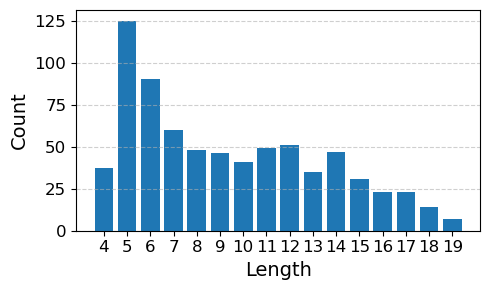

In [7]:
unique_lengths, counts = np.unique(lengths, return_counts=True)

# Plot
plt.figure(figsize=(5,3))
plt.bar(unique_lengths, counts, width=0.8, align='center')

# Set integer ticks on the x-axis
plt.xticks(np.arange(min(unique_lengths), max(unique_lengths)+1, 1))

# Labels and title
plt.xlabel("Length", fontsize=14)
plt.ylabel("Count", fontsize=14)

# Make tick labels larger
plt.tick_params(axis='both', which='major', labelsize=12)

plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

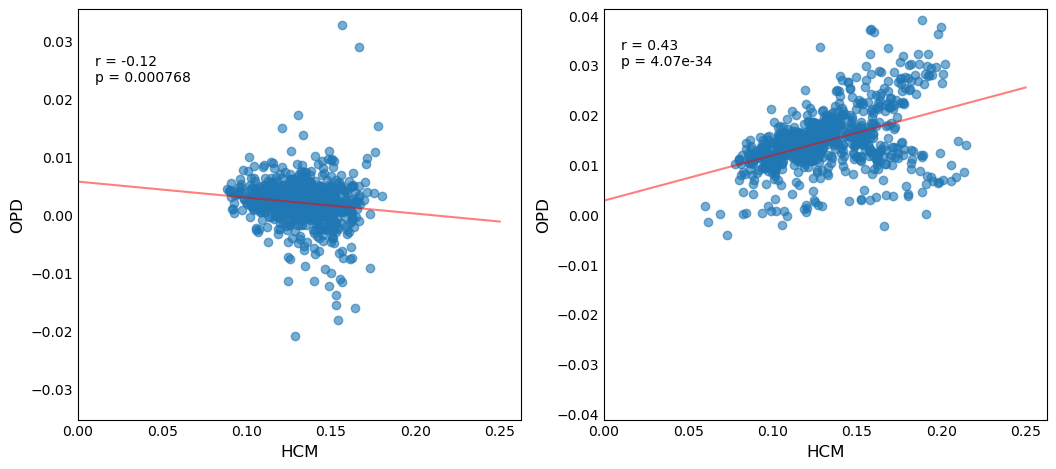

In [19]:
coarse_corr = scipy.stats.pearsonr(hcm_coarse, opd_coarse)
fine_corr = scipy.stats.pearsonr(hcm_fine, opd_fine)

fsize = 12

fig = plt.figure(figsize=plt.figaspect(0.45))

# Fine plot
ax2 = fig.add_subplot(1, 2, 1)
ax2.scatter(hcm_fine, opd_fine, alpha=0.6, edgecolors=None)

m, b = np.polyfit(hcm_fine, opd_fine, 1)
x = np.linspace(0, 0.25, 100)
ax2.plot(x, m * x + b, c='r', alpha=0.5)

ax2.set_xlabel('HCM', fontsize=fsize)
ax2.set_ylabel('OPD', fontsize=fsize)
ax2.annotate('r = %s\np = %s' % (float('%.2g' % fine_corr[0]), float('%.3g' % fine_corr[1])), (0.01, 0.023))

# Enforce x-axis starts at 0 and symmetric y-axis
ax2.set_xlim(left=0)
ymax = max(abs(ax2.get_ylim()[0]), abs(ax2.get_ylim()[1]))
ax2.set_ylim([-ymax, ymax])

# Remove tick marks but keep labels
ax2.tick_params(axis='both', length=0)



# Coarse plot
ax0 = fig.add_subplot(1, 2, 2)
ax0.scatter(hcm_coarse, opd_coarse, alpha=0.6, edgecolors=None)

m, b = np.polyfit(hcm_coarse, opd_coarse, 1)
x = np.linspace(0, 0.25, 100)
ax0.plot(x, m * x + b, c='r', alpha=0.5)

ax0.set_xlabel('HCM', fontsize=fsize)
ax0.set_ylabel('OPD', fontsize=fsize)
ax0.annotate('r = %s\np = %s' % (float('%.2g' % coarse_corr[0]), float('%.3g' % coarse_corr[1])), (0.01, 0.03))

# Enforce x-axis starts at 0 and symmetric y-axis
ax0.set_xlim(left=0)
ymax = max(abs(ax0.get_ylim()[0]), abs(ax0.get_ylim()[1]))
ax0.set_ylim([-ymax, ymax])

# Remove tick marks but keep labels
ax0.tick_params(axis='both', length=0)

plt.tight_layout()
plt.savefig('ints_CA.png', dpi=600)
plt.show()



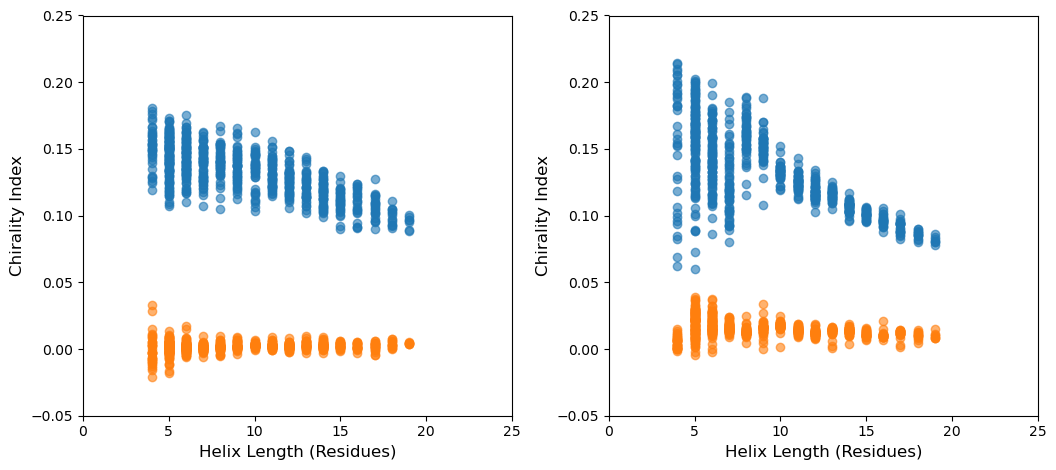

In [20]:
fsize=12

fig = plt.figure(figsize=plt.figaspect(0.45))

ax0 = fig.add_subplot(1, 2, 2)
ax0.scatter(lengths, hcm_coarse, alpha=0.6, edgecolors=None)
ax0.scatter(lengths, opd_coarse, alpha=0.6, edgecolors=None)


# m, b = np.polyfit(hcms[:,0],hcms[:,1], 1)
# x = np.linspace(0,0.25, 100)
# ax0.plot(x, m*x + b, c='r', alpha=0.5)

ax0.grid(False)
# ax0.axis('scaled')
ax0.set_xlim(0,25)
ax0.set_ylim(-0.05,0.25)
ax0.set_xlabel('Helix Length (Residues)', fontsize=fsize)
ax0.set_ylabel('Chirality Index', fontsize=fsize)
# ax0.annotate('r = %s' % float('%.2g' % hcm_corr[0]), (0.01, 0.235))
# ax0.annotate('p = %s' % float('%.3g' % hcm_corr[1]), (0.01, 0.225))

ax2 = fig.add_subplot(1, 2, 1)

ax2.scatter(lengths, hcm_fine, alpha=0.6, edgecolors=None)
ax2.scatter(lengths, opd_fine, alpha=0.6, edgecolors=None)

# m, b = np.polyfit(opds[:,0], opds[:,1], 1)
# x = np.linspace(-0.1,0.1, 100)
# ax2.plot(x, m*x + b, c='r', alpha=0.5)

# ax2.grid(False)
# ax2.axis('scaled')
ax2.set_xlim(0,25)
ax2.set_ylim(-0.05,0.25)
ax2.set_xlabel('Helix Length (Residues)', fontsize=fsize)
ax2.set_ylabel('Chirality Index', fontsize=fsize)
# ax2.annotate('r = %s' % float('%.1g' % opd_corr[0]), (-0.093,0.088))
# ax2.annotate('p = 0.20', (-0.093,0.08))
# ax2.tick_params(axis='x', labelrotation=30)
# # ax2.annotate('p = %s' % float('%.2g' % opd_corr[1]), (-0.093,0.08))

plt.tight_layout()
plt.savefig('ints_CA.png', dpi=600)
plt.show()

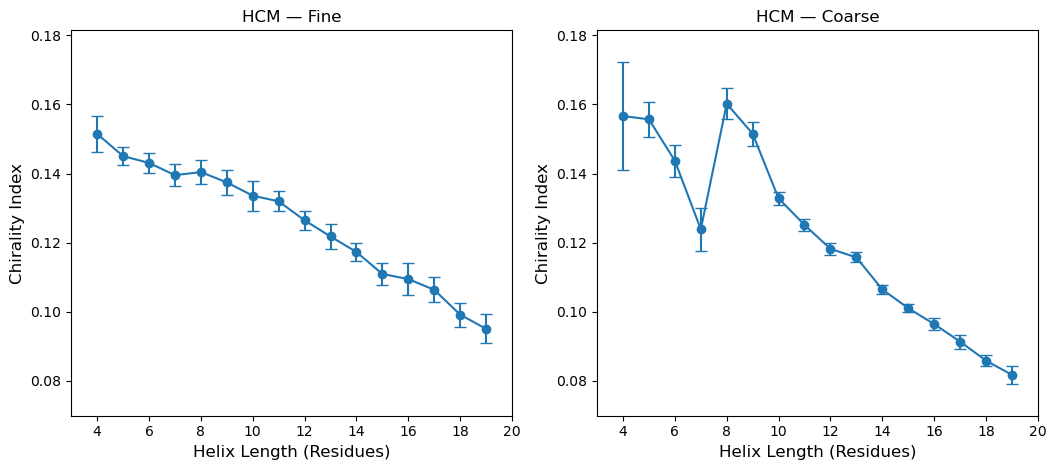

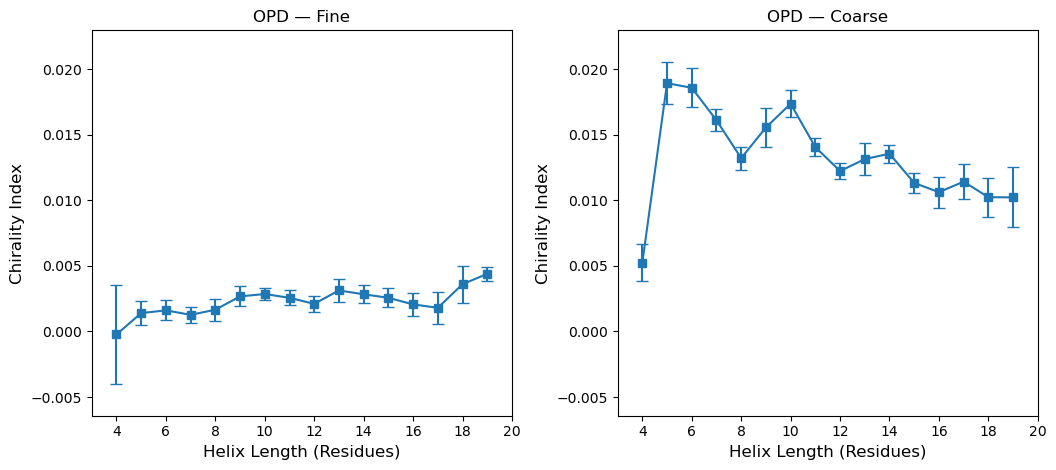

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

fsize = 12

def mean_and_ci(data, lengths):
    """Compute means and 95% CI half‐widths at each unique length."""
    unique_L = np.unique(lengths)
    means, cis = [], []
    for L in unique_L:
        vals = data[lengths == L]
        n    = len(vals)
        m    = vals.mean()
        sem  = vals.std(ddof=1) / np.sqrt(n) if n > 1 else 0.0
        t95  = stats.t.ppf(0.975, df=n-1) if n > 1 else 0.0
        means.append(m)
        cis.append(sem * t95)
    return unique_L, np.array(means), np.array(cis)

# ——— Compute stats for HCM ———
L, mean_hcm_fine,   ci_hcm_fine   = mean_and_ci(hcm_fine,   lengths)
_, mean_hcm_coarse, ci_hcm_coarse = mean_and_ci(hcm_coarse, lengths)

# dynamic HCM limits
all_hcm = np.hstack([
    mean_hcm_fine + ci_hcm_fine,
    mean_hcm_fine - ci_hcm_fine,
    mean_hcm_coarse + ci_hcm_coarse,
    mean_hcm_coarse - ci_hcm_coarse
])
hcm_margin = (all_hcm.max() - all_hcm.min()) * 0.10
hcm_ylim   = (all_hcm.min() - hcm_margin, all_hcm.max() + hcm_margin)
hcm_xlim   = (L.min() - 1, L.max() + 1)

# ——— Plot HCM figure ———
fig_hcm, axes_hcm = plt.subplots(1, 2, figsize=plt.figaspect(0.45))
axes_hcm[0].errorbar(L, mean_hcm_fine,   yerr=ci_hcm_fine,   fmt='-o', capsize=4)
axes_hcm[1].errorbar(L, mean_hcm_coarse, yerr=ci_hcm_coarse, fmt='-o', capsize=4)

for ax, title in zip(axes_hcm, ['HCM — Fine', 'HCM — Coarse']):
    ax.set_title(title,            fontsize=fsize)
    ax.set_xlabel('Helix Length (Residues)', fontsize=fsize)
    ax.set_ylabel('Chirality Index',       fontsize=fsize)
    ax.set_xlim(*hcm_xlim)
    ax.set_ylim(*hcm_ylim)

plt.tight_layout()
plt.savefig('HCM_means_CI_custom_axes.png', dpi=600)
plt.show()


# ——— Compute stats for OPD ———
L, mean_opd_fine,   ci_opd_fine   = mean_and_ci(opd_fine,   lengths)
_, mean_opd_coarse, ci_opd_coarse = mean_and_ci(opd_coarse, lengths)

# dynamic OPD limits
all_opd = np.hstack([
    mean_opd_fine + ci_opd_fine,
    mean_opd_fine - ci_opd_fine,
    mean_opd_coarse + ci_opd_coarse,
    mean_opd_coarse - ci_opd_coarse
])
opd_margin = (all_opd.max() - all_opd.min()) * 0.10
opd_ylim   = (all_opd.min() - opd_margin, all_opd.max() + opd_margin)
opd_xlim   = (L.min() - 1, L.max() + 1)

# ——— Plot OPD figure ———
fig_opd, axes_opd = plt.subplots(1, 2, figsize=plt.figaspect(0.45))
axes_opd[0].errorbar(L, mean_opd_fine,   yerr=ci_opd_fine,   fmt='-s', capsize=4)
axes_opd[1].errorbar(L, mean_opd_coarse, yerr=ci_opd_coarse, fmt='-s', capsize=4)

for ax, title in zip(axes_opd, ['OPD — Fine', 'OPD — Coarse']):
    ax.set_title(title,            fontsize=fsize)
    ax.set_xlabel('Helix Length (Residues)', fontsize=fsize)
    ax.set_ylabel('Chirality Index',       fontsize=fsize)
    ax.set_xlim(*opd_xlim)
    ax.set_ylim(*opd_ylim)

plt.tight_layout()
plt.savefig('OPD_means_CI_custom_axes.png', dpi=600)
plt.show()


In [22]:
mask = np.zeros_like(lengths, dtype=int)

unique_lengths = np.unique(lengths)

for l in unique_lengths:
    indices = np.where(lengths == l)[0]  
    selected = indices[:25]  
    mask[selected] = 1

In [23]:
lengths = lengths[mask == 1]
hcm_coarse = hcm_coarse[mask == 1]
opd_coarse = opd_coarse[mask == 1]
hcm_fine = hcm_fine[mask == 1]
opd_fine = opd_fine[mask == 1]

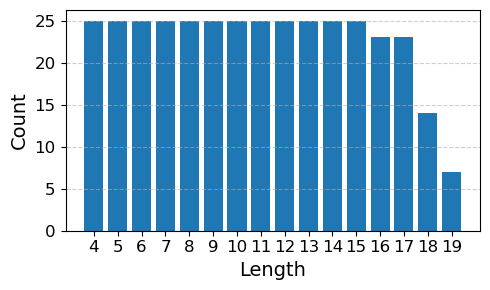

In [24]:
unique_lengths, counts = np.unique(lengths, return_counts=True)

plt.figure(figsize=(5,3))
plt.bar(unique_lengths, counts, width=0.8, align='center')

plt.xticks(np.arange(min(unique_lengths), max(unique_lengths)+1, 1))

plt.xlabel("Length", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

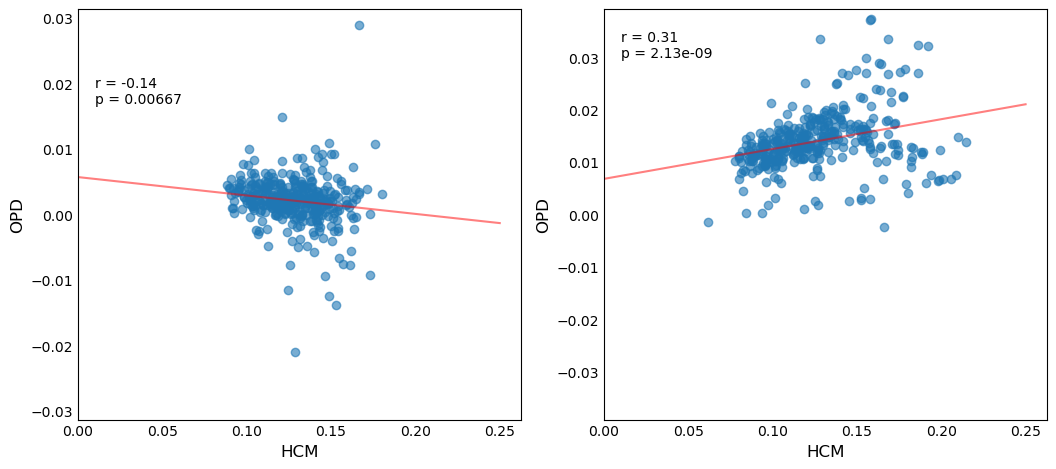

In [25]:
coarse_corr = scipy.stats.pearsonr(hcm_coarse, opd_coarse)
fine_corr = scipy.stats.pearsonr(hcm_fine, opd_fine)

fsize = 12

fig = plt.figure(figsize=plt.figaspect(0.45))

# Fine plot
ax2 = fig.add_subplot(1, 2, 1)
ax2.scatter(hcm_fine, opd_fine, alpha=0.6, edgecolors=None)

m, b = np.polyfit(hcm_fine, opd_fine, 1)
x = np.linspace(0, 0.25, 100)
ax2.plot(x, m * x + b, c='r', alpha=0.5)

ax2.set_xlabel('HCM', fontsize=fsize)
ax2.set_ylabel('OPD', fontsize=fsize)
ax2.annotate('r = %s\np = %s' % (float('%.2g' % fine_corr[0]), float('%.3g' % fine_corr[1])), (0.01, 0.017))

# Enforce x-axis starts at 0 and symmetric y-axis
ax2.set_xlim(left=0)
ymax = max(abs(ax2.get_ylim()[0]), abs(ax2.get_ylim()[1]))
ax2.set_ylim([-ymax, ymax])

# Remove tick marks but keep labels
ax2.tick_params(axis='both', length=0)



# Coarse plot
ax0 = fig.add_subplot(1, 2, 2)
ax0.scatter(hcm_coarse, opd_coarse, alpha=0.6, edgecolors=None)

m, b = np.polyfit(hcm_coarse, opd_coarse, 1)
x = np.linspace(0, 0.25, 100)
ax0.plot(x, m * x + b, c='r', alpha=0.5)

ax0.set_xlabel('HCM', fontsize=fsize)
ax0.set_ylabel('OPD', fontsize=fsize)
ax0.annotate('r = %s\np = %s' % (float('%.2g' % coarse_corr[0]), float('%.3g' % coarse_corr[1])), (0.01, 0.03))

# Enforce x-axis starts at 0 and symmetric y-axis
ax0.set_xlim(left=0)
ymax = max(abs(ax0.get_ylim()[0]), abs(ax0.get_ylim()[1]))
ax0.set_ylim([-ymax, ymax])

# Remove tick marks but keep labels
ax0.tick_params(axis='both', length=0)

plt.tight_layout()
plt.savefig('ints_CA.png', dpi=600)
plt.show()

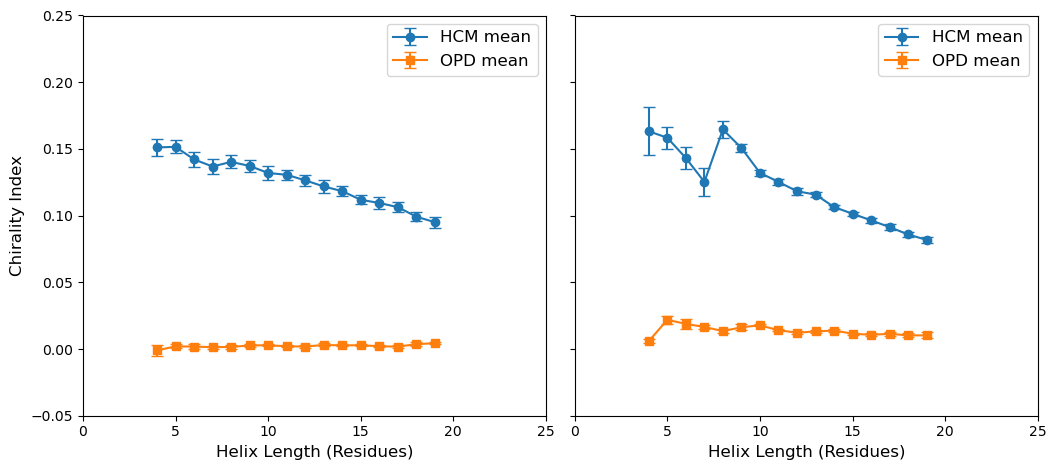

In [26]:
fsize = 12

# figure with two side‐by‐side panels
fig, (ax2, ax0) = plt.subplots(1, 2, figsize=plt.figaspect(0.45), sharex=True, sharey=True)

# get sorted unique lengths
unique_lengths = np.unique(lengths)

def mean_and_ci(data):
    """Return arrays of means and 95%‐CI half‐widths for each unique length."""
    means = []
    cis   = []
    for L in unique_lengths:
        vals = data[lengths == L]
        n    = len(vals)
        m    = vals.mean()
        # standard error
        sem  = vals.std(ddof=1) / np.sqrt(n)
        # t‐multiplier for 95% CI, df = n‑1 (if n>1)
        t_mul = stats.t.ppf(0.975, df=n-1) if n > 1 else np.nan
        ci    = sem * t_mul
        means.append(m)
        cis.append(ci)
    return np.array(means), np.array(cis)

# compute stats for fine
mean_hcm_fine, ci_hcm_fine = mean_and_ci(hcm_fine)
mean_opd_fine, ci_opd_fine = mean_and_ci(opd_fine)

# plot fine panel (left)
ax2.errorbar(unique_lengths, mean_hcm_fine, yerr=ci_hcm_fine,
             fmt='-o', capsize=4, label='HCM mean')
ax2.errorbar(unique_lengths, mean_opd_fine, yerr=ci_opd_fine,
             fmt='-s', capsize=4, label='OPD mean')

ax2.set_xlabel('Helix Length (Residues)', fontsize=fsize)
ax2.set_ylabel('Chirality Index',       fontsize=fsize)
ax2.set_xlim(0, 25)
ax2.set_ylim(-0.05, 0.25)
ax2.legend(fontsize=fsize)

# compute stats for coarse
mean_hcm_coarse, ci_hcm_coarse = mean_and_ci(hcm_coarse)
mean_opd_coarse, ci_opd_coarse = mean_and_ci(opd_coarse)

# plot coarse panel (right)
ax0.errorbar(unique_lengths, mean_hcm_coarse, yerr=ci_hcm_coarse,
             fmt='-o', capsize=4, label='HCM mean')
ax0.errorbar(unique_lengths, mean_opd_coarse, yerr=ci_opd_coarse,
             fmt='-s', capsize=4, label='OPD mean')

ax0.set_xlabel('Helix Length (Residues)', fontsize=fsize)
ax0.set_xlim(0, 25)
ax0.set_ylim(-0.05, 0.25)
ax0.legend(fontsize=fsize)

plt.tight_layout()
plt.savefig('ints_CA_means_CI.png', dpi=600)
plt.show()